# Busca no Espaço de Configuração - Hiperparameter Tunning

# Índice:
   * [Descrição](#description)
      * [Objetivos](#goals)
   * [Imports](#imports)
   * [Extrção e Transformação](#extraction)
   * [Parâmtetros](#parameters)
      * [Introdução a Modelos de Árvores de Decisão](#decisiontree)
      * [Espaço de Busca](#searchspace)
      * [Log no MLFlow](#mlflow) 

## Descrição <a class="anchor" id="description"></a>

Esse notebook implementa a busca por híperparâmetros ótimos para o modelo de Árvore de Decisão. Esse modelo foi escolhido por ter um espaço de parâmetros com múltiplas dimensões e por possuir métodos que permitem analisar a tomada de decisão do modelo treinado.

### Objetivos  <a class="anchor" id="goals"></a>

* desenvolver funções para a busca nos híperparâmetros (incluindo a validação e log no MLFlow),
* realizar a análise do desempenho do modelo no espaço dos parâmetros,
* entender como o modelo de arvore de decisão se aplica aos dados do problema

## Imports  <a class="anchor" id="imports"></a>

In [1]:
import os
import sys
from tabnanny import verbose
import pandas as pd
import numpy as np
import yaml
from itertools import chain, combinations
import datetime
import tempfile

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.utils import shuffle

import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient
from mlflow.utils.mlflow_tags import MLFLOW_PARENT_RUN_ID

import matplotlib.pyplot as plt
import seaborn as sns

## Extração e Transformação <a class="anchor" id="extraction"></a>

A busca nos híper-parâmetros é feita no conjunto de treino, e o algoritmo de validação cruzada separa uma porção desse conjunto a cada iteração para usar como teste. Ao final, se o objetivo for produzir um modelo treinado, é utilizado um conjunto de validação para aferir o desempenho do melhor estimador encontrado na busca.

Abaixo são separados os conjuntos de treino e validação

In [2]:
def read_data(url):
    return pd.read_csv(os.path.abspath(url))

In [3]:
df = read_data("../extracao/datanov2.csv")

In [4]:
def getXy(df):
    r_state = 15
    df = shuffle(df, random_state=r_state)
    X = df.iloc[:,:-1]
    y = df.iloc[:,-1]
    return X, y
r_state = 12
X, y = getXy(df)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=r_state
)


## Parâmetros <a class="anchor" id="parameters"></a>

### Espaço de Busca <a class="anchor" id="searchspace"></a>

Este notebook implementa duas estratégias de busca nos híper-parâmetros: a busca randômica e a busca em grade.
Na busca em randômica são passados, para cada parâmetro, os valores superiores e inferiores para o intervalo de busca e o número de iterações. O algoritmo irá gerar valores aleatórios dentro destes intervalos para cada iteração, com base na semente passada para o gerador aleatório.

Na busca em grade são passados um conjunto de valores para cada parâmetro e o algoritmo executará todas as combinações. 

Em ambos os casos, são passadas métricas de desempenho e uma delas deve ser determinada como o _score_ a ser utilizado na seleção do melhor modelo. Por motivos de otimização, a biblioteca _Sklearn_ utiliza funções de métricas que são maiores quanto melhor o modelo. Com isso as funções de erro absoluto (funções as quais um valor menor indica um modelo melhor) são multiplicadas por -1, para que cresçam conforme o desempenho do modelo melhora.

### Introdução a Modelos de Árvores de Decisão <a class="ancho" id="decisiontree"></a>

Uma breve descrição do modelo de árvore de decisão é necessária para proceder na busca por híper-parâmetros, com o intuito de se entender melhor os argumentos os quais se deseja maximizar.

Árvores de decisão são grafos acíclicos que podem ser usados para realizar decisões. Em cada nó interno da árvore possui um índice de uma das características e um limiar. Um input que seja analisado nesse nó seguirá na subárvore à esquerda desse nó se o valor da característica indexada no nó for menor que o limiar, e seguirá na subárvore da direita se for maior. Nas folhas é feita a previsão, que é constante para todos os nós que terminarem de percorrer a árvore naquele nó. Dessa forma, uma árvore é uma aproximação  constante em trechos do domínio.




In [6]:
range_grid = {
    "max_features":[ 2, 6, 3],
    "max_depth": [ 2, 10, 5],
    "min_samples_split": [ 5, 25, 10],
    "min_samples_leaf": [ 4, 20, 10]
}

In [7]:
param_grid = {}
for k, v in range_grid.items():
        param_grid[k] = range(v[0], v[1], v[2])

In [8]:
param_grid

{'max_features': range(2, 6, 3),
 'max_depth': range(2, 10, 5),
 'min_samples_split': range(5, 25, 10),
 'min_samples_leaf': range(4, 20, 10)}

## Treinamento

In [9]:
skmodel = DecisionTreeRegressor()

In [29]:
_scoring = {
    "r2",
    "neg_mean_absolute_error",
    "neg_root_mean_squared_error",
}
gsCV = GridSearchCV(
    skmodel, param_grid, scoring=_scoring, refit="r2"
)

In [32]:
gsCV.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': range(2, 10, 5),
                         'max_features': range(2, 6, 3),
                         'min_samples_leaf': range(4, 20, 10),
                         'min_samples_split': range(5, 25, 10)},
             refit='r2',
             scoring={'neg_mean_absolute_error', 'neg_root_mean_squared_error',
                      'r2'})

In [12]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

## Validação

In [15]:
predicted_qualities = gsCV.predict(X_val)
predicted_qualities_train = gsCV.predict(X_train)

rmse, mae, r2 = eval_metrics(y_train, predicted_qualities_train)
print (f"Desempenho no conjunto de Treino\nrmse:{rmse}    mae:{mae}    r2:{r2}")

rmse, mae, r2 = eval_metrics(y_val, predicted_qualities)
print (f"Desempenho no conjunto de Testes (Validação)\nrmse:{rmse}    mae:{mae}    r2:{r2}")


Desempenho no conjunto de Treino
rmse:12.573345341021078    mae:9.799214426944053    r2:0.34933113394122606
Desempenho no conjunto de Testes (Validação)
rmse:12.875871590686993    mae:10.025237227387619    r2:0.2685882441620445


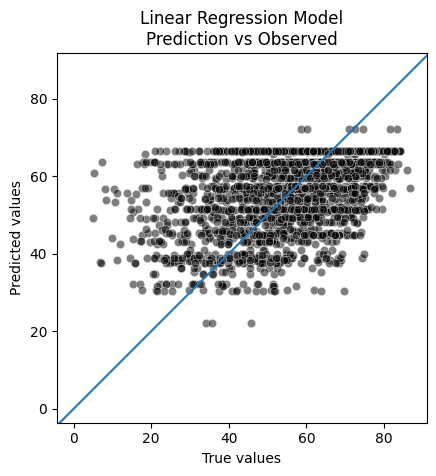

In [17]:
predicted_actual = {
    "True values": y_val, "Predicted values": predicted_qualities}
predicted_actual = pd.DataFrame(predicted_actual)

sns.scatterplot(data=predicted_actual,
                x="True values", y="Predicted values",
                color="black", alpha=0.5)
plt.axline((0, 0), slope=1, label="Perfect fit")
plt.axis('square')
_ = plt.title("Linear Regression Model\nPrediction vs Observed")

## Log no MLFlow <a class="anchor" id="mlflow"></a>

## Importância das Características <a class="anchor" id="featureimportance"></a>


In [18]:
gsCV.best_estimator_.feature_importances_

array([0.04972413, 0.02867457, 0.5347888 , 0.13553725, 0.02598043,
       0.22529482])

In [25]:
cvresults = pd.DataFrame(gsCV.cv_results_)

In [26]:
cvresults

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,params,split0_test_neg_root_mean_squared_error,...,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,split4_test_r2,mean_test_r2,std_test_r2,rank_test_r2
0,0.007686,0.003781,0.004463,0.003487,2,2,4,5,"{'max_depth': 2, 'max_features': 2, 'min_sampl...",-14.659661,...,0.309774,16,0.129914,0.051175,0.088220,0.022719,0.163669,0.091139,0.051090,16
1,0.003175,0.000253,0.001762,0.000079,2,2,4,15,"{'max_depth': 2, 'max_features': 2, 'min_sampl...",-14.328700,...,0.256562,14,0.168757,0.081719,0.074093,0.139402,0.184451,0.129684,0.044747,14
2,0.003161,0.000161,0.001727,0.000055,2,2,14,5,"{'max_depth': 2, 'max_features': 2, 'min_sampl...",-14.504968,...,0.158120,13,0.148180,0.177241,0.154185,0.155135,0.162022,0.159353,0.009964,12
3,0.003480,0.000650,0.002060,0.000412,2,2,14,15,"{'max_depth': 2, 'max_features': 2, 'min_sampl...",-15.224086,...,0.451648,15,0.061624,0.192610,0.083714,0.030071,0.139368,0.101477,0.057868,15
4,0.004862,0.000480,0.001912,0.000175,2,5,4,5,"{'max_depth': 2, 'max_features': 5, 'min_sampl...",-14.268946,...,0.157135,9,0.175676,0.180090,0.156640,0.173119,0.155447,0.168194,0.010176,9
5,0.004690,0.000130,0.001787,0.000064,2,5,4,15,"{'max_depth': 2, 'max_features': 5, 'min_sampl...",-14.268946,...,0.111423,11,0.175676,0.123743,0.154185,0.173119,0.186152,0.162575,0.021986,11
6,0.004750,0.000188,0.001766,0.000058,2,5,14,5,"{'max_depth': 2, 'max_features': 5, 'min_sampl...",-14.660486,...,0.199041,10,0.129816,0.192610,0.154185,0.153831,0.184451,0.162979,0.022803,10
7,0.004719,0.000227,0.001745,0.000044,2,5,14,15,"{'max_depth': 2, 'max_features': 5, 'min_sampl...",-14.660486,...,0.141580,12,0.129816,0.150919,0.154185,0.173119,0.186152,0.158838,0.019373,13
8,0.005466,0.000129,0.001868,0.000045,7,2,4,5,"{'max_depth': 7, 'max_features': 2, 'min_sampl...",-14.103369,...,0.118414,8,0.194696,0.172039,0.166299,0.193789,0.245820,0.194529,0.028050,8
9,0.006611,0.000716,0.002091,0.000222,7,2,4,15,"{'max_depth': 7, 'max_features': 2, 'min_sampl...",-14.110394,...,0.175632,6,0.193893,0.188246,0.196229,0.221412,0.264155,0.212787,0.028094,4


In [65]:
column_results = [
    f"param_{name}" for name in param_grid.keys()]
column_results += [
   "mean_test_r2"]
#, "std_test_r2", "rank_test_r2"]

cv_results = pd.DataFrame(gsCV.cv_results_)
print (cv_results)
cv_results = cv_results[column_results].sort_values(
    "mean_test_r2", ascending=False)

def shorten_param(param_name):
    if "param_" in param_name:
        return param_name.rsplit("param_", 1)[1]
    return param_name


cv_results = cv_results.rename(shorten_param, axis=1)
cv_results

    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.074599      0.130549         0.012441        0.015730   
1        0.002983      0.000345         0.001755        0.000086   
2        0.003135      0.000262         0.001791        0.000141   
3        0.003235      0.000235         0.001781        0.000058   
4        0.004590      0.000209         0.001719        0.000055   
5        0.004805      0.000103         0.001735        0.000053   
6        0.004667      0.000161         0.001719        0.000049   
7        0.004745      0.000128         0.001775        0.000081   
8        0.005934      0.000299         0.001752        0.000015   
9        0.006143      0.000388         0.001771        0.000038   
10       0.005844      0.000383         0.001753        0.000048   
11       0.006122      0.000308         0.001816        0.000065   
12       0.011321      0.000200         0.001847        0.000056   
13       0.012596      0.001093         0.002245

,max_features,max_depth,min_samples_split,min_samples_leaf,mean_test_r2
14,5,7,5,14,0.240744
15,5,7,15,14,0.233796
12,5,7,5,4,0.225143
11,2,7,15,14,0.219313
9,2,7,15,4,0.216951
13,5,7,15,4,0.213592
10,2,7,5,14,0.212971
8,2,7,5,4,0.206343
6,5,2,5,14,0.174335
7,5,2,15,14,0.173301


In [ ]:
import plotly.express as px

fig = px.parallel_coordinates(
    cv_results.apply(
        {
            "max_features": lambda x: x,
            "max_depth": lambda x: x,
            "min_samples_split": lambda x: x,
            "min_samples_leaf": lambda x: x,
            "mean_test_r2": lambda x: x,
        }),
    color="mean_test_r2",
    color_continuous_scale=px.colors.sequential.Viridis,
)
fig.show()